In [1]:
# Reference to ../src
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from interpretability.utils import visualize_cam, Normalize
from interpretability.gradcam import GradCAM, GradCAMpp

import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

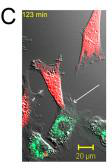

In [2]:
import cv2
pil_img = PIL.Image.open('/mnt/test/DMEL/1471-2121-11-29-4-3.jpg')
# pil_img = PIL.Image.open('/mnt/test/DMEL/1742-9994-7-30-1-1.jpg')
# pil_img = PIL.Image.open('/mnt/test/DMEL/1471-213X-7-28-2-8.jpg')
# pil_img = PIL.Image.open('/mnt/test/DMFL/1471-2180-11-111-1-1.jpg')
# pil_img = PIL.Image.open('/mnt/test/DMLI/1471-2202-9-96-3-2.jpg')
#pil_img = PIL.Image.open('/mnt/test/DMEL/1471-213X-10-88-7-7.jpg')
# pil_img = PIL.Image.open('/mnt/test/DMTR/1744-8069-5-39-4-3.jpg')


# ii = cv2.imread('/mnt/test/DMEL/1471-2121-11-29-4-3.jpg')
# ii = cv2.imread('/mnt/test/DMEL/1742-9994-7-30-1-1.jpg')
# ii = cv2.imread('/mnt/test/DMTR/1744-8069-5-39-4-3.jpg')

# gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)

# ii[:,:,0] = gray_image
# ii[:,:,1] = gray_image
# ii[:,:,2] = gray_image

# pil_img = PIL.Image.fromarray(ii)
pil_img

In [3]:
normalizer = Normalize(mean=[0.4857, 0.4740, 0.4755], std=[0.3648, 0.3557, 0.3669])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [4]:
from experiments.microscopy.microscopy import experiment
model_weights = {
    'resnet50.whole.loss': 'devoted-valley-99',
}

def load_model(model_id):
    model_name, experiment_name, _ = model_id.split('.')
    model = experiment(experiment_name, model_name, num_classes=4, pretrained=True)
    
    checkpoint = torch.load('../outputs/{0}/checkpoint.pt'.format(model_weights[model_id]))
    model.load_state_dict(checkpoint)
    
    return model

resnet = load_model('resnet50.whole.loss')
resnet.eval(), resnet.cuda();

In [5]:
def plot_maps(layer_name):
    cam_dict = dict()
    resnet_model_dict = dict(type='resnet', arch=resnet, layer_name=layer_name, input_size=(224, 224))
    resnet_gradcam = GradCAM(resnet_model_dict, True)
    resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
    cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

    images = []
    for gradcam, gradcam_pp in cam_dict.values():
        mask, _ = gradcam(normed_torch_img)
        heatmap, result = visualize_cam(mask.cpu(), torch_img.cpu())

        mask_pp, _ = gradcam_pp(normed_torch_img)
        heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img.cpu())

        images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    return images


saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


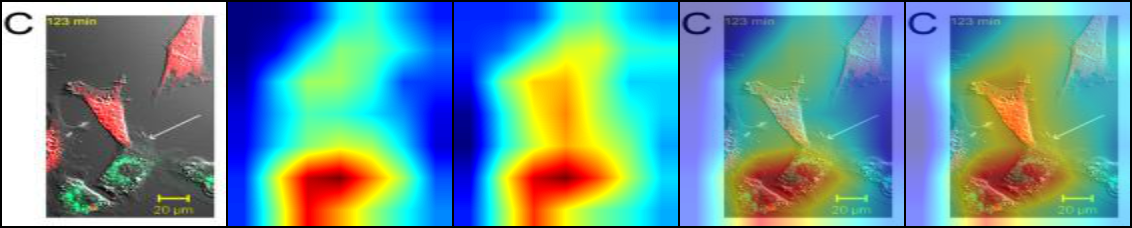

In [6]:
images =plot_maps('layer4')
images = make_grid(torch.cat(images, 0), nrow=5)

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = 'test.png'
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])


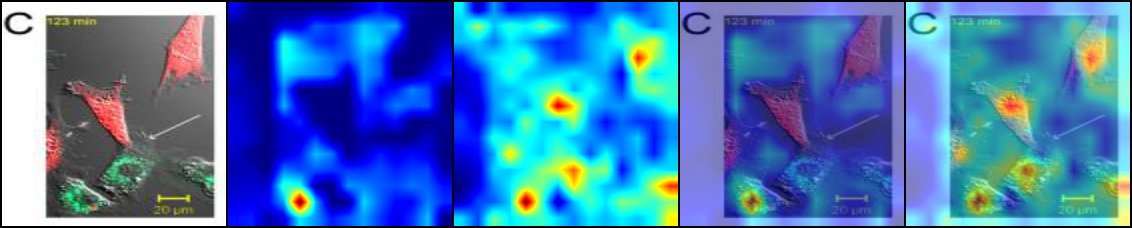

In [7]:
images =plot_maps('layer3')
images = make_grid(torch.cat(images, 0), nrow=5)

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = 'test.png'
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

saliency_map size : torch.Size([28, 28])
saliency_map size : torch.Size([28, 28])


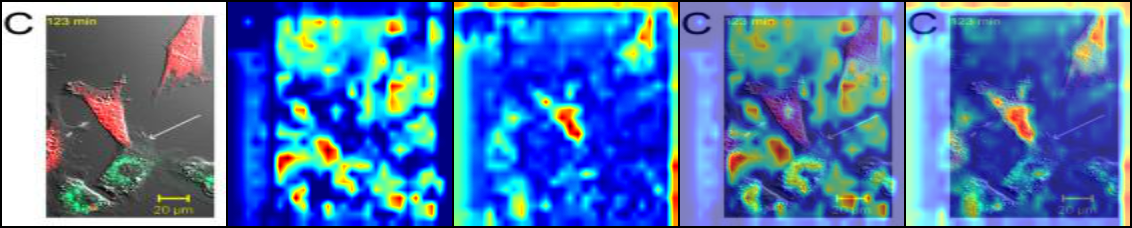

In [8]:
images =plot_maps('layer2')
images = make_grid(torch.cat(images, 0), nrow=5)

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = 'test.png'
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])


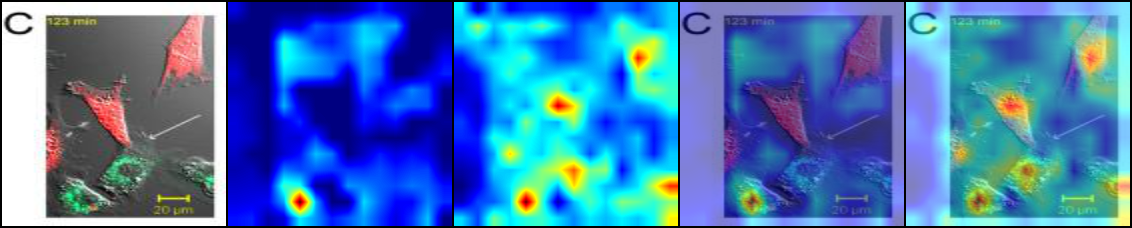

In [9]:
images =plot_maps('layer3_basicblock5')
images = make_grid(torch.cat(images, 0), nrow=5)

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = 'test.png'
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

In [10]:
outputs = resnet(torch_img)
_, predicted = torch.max(outputs.data, 1)

In [11]:
predicted

tensor([2], device='cuda:0')